Modify the KNN scratch code in our lecture such that:
- If the majority class of the first place is equal to the second place, then ask the algorithm to pick the next nearest neighbors as the decider
- Modify the code so it outputs the probability of the decision, where the probability is simply the class probability based on all the nearest neighbors
- Write a function which allows the program to receive a range of k, and output the cross validation score.  Last, it shall inform us which k is the best to use from a predefined range
- Put everything into a class <code>KNN(k=3)</code>.  It should have at least one method, <code>predict(X_train, X_test, y_train)</code>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

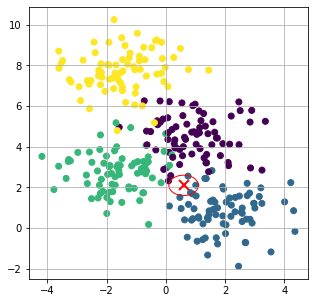

In [2]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
xfit = np.linspace(-1, 3.5)
figure = plt.figure(figsize=(5, 5))
ax = plt.axes() 
ax.grid()
ax.scatter(X[:, 0], X[:, 1], c=y)

#where should this value be classified as?
ax.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
#let's say roughly 5 neighbors
circle = plt.Circle((0.6, 2.1), 0.5, color='red', fill=False)
ax.add_artist(circle)
#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
class KNN:
    def __init__(self, k= 3):
        self.k = k
    
    def find_distance(self,X_train,X_test):
        #create newaxis simply so that broadcast to all values
        dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
        sq_dist = dist ** 2
        #sum across feature dimension, thus axis = 2
        summed_dist = sq_dist.sum(axis=2)
        sq_dist = np.sqrt(summed_dist)
        return sq_dist

      # get index of (m(X_test),n(X_train))
    def find_neighbors(self,X_train, X_test, k=3):
        dist = self.find_distance(X_train, X_test)
        #return the first k neighbors
        neighbors_ix = np.argsort(dist)[:, 0:k]
        return neighbors_ix

    def find_neighbors_without_k(self, X_train, X_test):
        dist = self.find_distance(X_train, X_test)
        #return the first k neighbors
        neighbors_ix = np.argsort(dist)
        return neighbors_ix

    # get array of the most neighbors 
    def get_most_common(self, y, n_classes):
        y_nearest = y[0:self.k]
        bincount = np.bincount(y_nearest, minlength=n_classes)
        largest = bincount.argmax()
        second_largest = bincount.argsort()[-2:][0]
        #if the first two most common is the same, we take the third most common as the decider
        if bincount[largest] == bincount[second_largest]:
            y_nearest = y[0: self.k+1]  #add one more neighbor
            return np.bincount(y_nearest).argmax(), bincount[largest] / bincount.sum()
        return np.bincount(y_nearest).argmax(), bincount[largest] / bincount.sum()

    def predict(self, X_train, X_test, y_train):
        n_classes = len(np.unique(y_train))
        neighbors_ix = self.find_neighbors_without_k(X_train, X_test)
        yhat = np.zeros(X_test.shape[0])
        yhat_prob = np.zeros(X_test.shape[0])
        for ix, y in enumerate(y_train[neighbors_ix]):
            yhat[ix], yhat_prob[ix] = self.get_most_common(y, n_classes)
        return yhat, yhat_prob
    
    def cv(self, X_train, y_train, cv, k):
            foldsize = int(X_train.shape[0]/cv)
            yhat_cv = np.zeros((len(k), cv))
            yhat_cv_prob = np.zeros((len(k), cv))
            
            for k_idx, kneighbors in enumerate(k):
                self.k = kneighbors
                for fold_idx, i in enumerate(range(0, X_train.shape[0], foldsize)):
                    X_test_ = X_train[i:i+foldsize]
                    y_test_ = y_train[i:i+foldsize]
                    X_train_ = np.concatenate((X_train[:i], X_train[i+foldsize:]))
                    y_train_ = np.concatenate((y_train[:i], y_train[i+foldsize:]))
                    yhat, yhat_prob = self.predict(X_train_, X_test_, y_train_)
                    accuracy = np.sum(yhat == y_test_)/len(y_test_)
                    yhat_cv[k_idx, fold_idx] = accuracy
                    yhat_cv_prob[k_idx, fold_idx] = yhat_prob.mean()
            return yhat_cv, yhat_cv_prob
    
    def check_cv(self,X_train, y_train, cv = 10, k=0) : 
        k = np.arange(2, 11)
        cv_score, prob_score = self.cv(X_train, y_train, 10, k)
        cv_score = cv_score.mean(axis=1)
        prob_score = prob_score.mean(axis=1)
        for k_idx, kneighbors in enumerate(k):
            print(f"Score with k={kneighbors}: ", cv_score[k_idx], "and prob_score of ", prob_score[k_idx])

    def predict_report(self,yhat, yhat_prob):
        print("=========Accuracy=======")
        print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))
        print("=========Classification report=======")
        print("Report: ", classification_report(y_test, yhat))
        print("=========Probability score=======")
        print("Probability: ", yhat_prob.mean())


In [6]:
model = KNN()
#check cv
model.check_cv(X_train, y_train, cv = 10, k= np.arange(2, 11))
#choose model with highest score
model = KNN(k=2)
yhat, yhat_prob = model.predict(X_train, X_test, y_train)
model.predict_report(yhat, yhat_prob)


Score with k=2:  0.8904761904761905 and prob_score of  0.9428571428571428
Score with k=3:  0.8904761904761905 and prob_score of  0.9396825396825397
Score with k=4:  0.9142857142857143 and prob_score of  0.9273809523809524
Score with k=5:  0.9095238095238095 and prob_score of  0.9238095238095239
Score with k=6:  0.919047619047619 and prob_score of  0.9222222222222222
Score with k=7:  0.919047619047619 and prob_score of  0.919047619047619
Score with k=8:  0.9095238095238095 and prob_score of  0.918452380952381
Score with k=9:  0.9095238095238095 and prob_score of  0.9164021164021164
Score with k=10:  0.9095238095238095 and prob_score of  0.9095238095238096
=========Accuracy=======
Accuracy:  0.9555555555555556
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       1.00      1.00      1.00        25
           2       0.94      0.88      0.91        17
           3      